In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff

import time
import tracemalloc
# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7fc34bc53a30>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [2]:
# check if the overlay works
def overlaySegment(gray1,seg1,flag=False):
    H, W = seg1.squeeze().size()
    colors=torch.FloatTensor([0,0,0,199,67,66,225,140,154,78,129,170,45,170,170,240,110,38,111,163,91,235,175,86,202,255,52,162,0,183]).view(-1,3)/255.0
    segs1 = labelMatrixOneHot(seg1.unsqueeze(0),8)

    seg_color = torch.mm(segs1.view(8,-1).t(),colors[:8,:]).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(seg1>0).float(),0,1.0)

    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    if(flag):
        plt.imshow((overlay).numpy())
        plt.show()
    return overlay
def labelMatrixOneHot(segmentation, label_num):
    B, H, W = segmentation.size()
    values = segmentation.view(B,1,H,W).expand(B,label_num,H,W).to(segmentation.device)
    linspace = torch.linspace(0, label_num-1, label_num).long().view(1,label_num,1,1).expand(B,label_num,H,W).to(segmentation.device)
    matrix = (values.float()==linspace.float()).float().to(segmentation.device)
    for j in range(2,matrix.shape[1]):
        matrix[0,j,:,:] = matrix[0,j,:,:]
    return matrix

In [3]:
W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
disp_hw = 5
displace_range = 11

grid_size = 32#25#30
#grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    
    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [29]:
ensemble_model = OBELISK2d(16)

ensemble_model.load_state_dict(torch.load("models/Experiment_2/obel16_ensemble_soft_27_10_21-13-26.pth"))

ensemble_model=ensemble_model.cuda()

In [5]:
pwc = load_pwcnet().cuda()
flownet = load_flownet2().cuda()

In [48]:
path_to_data = "/share/data_ultraschall/compressions"
ids = [157, 384, 717]
# TODO: should become a loop later to eval all three patients at a time
prob_id= str(ids[2])
frame_path = os.path.join(path_to_data,prob_id,'frames')
seg_path = os.path.join(path_to_data,prob_id,'segmentations','1')

frame_list = []
for frame in os.listdir(frame_path):
    frame_list.append(os.path.join(frame_path,frame))
frame_list.sort()

seg_list = []
for seg in os.listdir(seg_path):
    seg_list.append(os.path.join(seg_path,seg))
seg_list.sort()

assert len(frame_list) == len(seg_list)
frames = torch.zeros([len(frame_list), 150,150])
segs = torch.zeros([len(frame_list), 150,150])
for i in range(len(frame_list)):
    frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255
    segs[i] = (torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100)
    
landmarks = pd.read_csv('landmarks.csv')
landmarks[landmarks['Id'].isin(ids)]

last_segment_available = np.fromstring(landmarks[landmarks['Id']== int(prob_id)]['Start Frames'].iat[0].strip(']['), sep=',', dtype=int)[0]
last_segment_available

68

In [49]:
def pdd_warp(model, fixed, moving, fixed_seg, moving_seg):
    model.eval()
    
    start = time.time()
    feat1 = model(fixed.unsqueeze(0).unsqueeze(0).cuda())
    feat2 = model(moving.unsqueeze(0).unsqueeze(0).cuda())
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150))
    end = time.time()
    run_time = round(end-start, 4)
    
    identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
    warped_student_seg = F.grid_sample(moving_seg.unsqueeze(0).unsqueeze(0).float().cuda(),identity+flow.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    return warped_student_seg, run_time


def flownet_warp(fixed, moving, fixed_seg, moving_seg):
    scale=4
    B,C,H,W = fixed.shape
    teacher_fixed = F.interpolate(fixed, size=(4*64,4*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(4*64,4*64), mode='bicubic')
    # Generate the teacher flow estimation
    flow_in = preprocessing_flownet(teacher_fixed.reshape(scale*64,scale*64,1),teacher_moving.reshape(scale*64,scale*64,1))
    
    start = time.time()
    
    flownet_flow = flownet(flow_in.cuda()).cpu()
    
    end = time.time()
    run_time = end-start
    
    flownet_flow = F.interpolate(flownet_flow, size=(H,W), mode='bicubic')

    # warp segmentation with flownet flow
    warped_flownet_seg = warp(fixed_seg.float().unsqueeze(0).unsqueeze(0), flownet_flow.flip(1))
    
    return warped_flownet_seg, run_time

def pwc_warp(fixed, moving, fixed_seg, moving_seg):
    scale=4
    B,C,H,W = fixed.shape
    
    teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')

    # Generate the teacher flow estimation
    pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1))
    
    start = time.time()
    pwc_flow = pwc(pwc_flow_in.cuda()).cpu()
    pwc_flow = pwc_flow[0] * 20.0
    
    end = time.time()
    run_time = end-start
    
    pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W)).cpu()

    # warp the segmentations with pwc flow
    warped_pwc_seg = warp(fixed_seg.float().unsqueeze(0).unsqueeze(0), pwc_flow.flip(1)).cpu()
    
    return warped_pwc_seg, run_time
    

In [50]:
distance_between_frames = 6

base_segs = torch.zeros(segs.shape)
pwc_segs = torch.zeros(segs.shape)
flow_segs = torch.zeros(segs.shape)


base_time = torch.zeros(frames.shape[0] - distance_between_frames)
pwc_time = torch.zeros(frames.shape[0] - distance_between_frames)
flow_time = torch.zeros(frames.shape[0] - distance_between_frames)


base_dice = torch.zeros(frames.shape[0],2)
pwc_dice = torch.zeros(frames.shape[0],2)
flow_dice = torch.zeros(frames.shape[0],2)

for i, frame in enumerate(frames):
    
    # skipp first X frames
    if i < distance_between_frames:
        continue
    moving = torch.clone(frames[i])
    fixed = torch.clone(frames[i- distance_between_frames])
    moving_seg = torch.clone(segs[i])
    fixed_seg = torch.clone(segs[i-distance_between_frames])
    
    # BASELINE (PDD on Soft targets)
    base_seg, run_time_base = pdd_warp(ensemble_model, fixed, moving, fixed_seg, moving_seg)
    base_segs[i] = base_seg.detach().cpu()
    base_time[i-distance_between_frames] = run_time_base
    base_dice[i] = dice_coeff(moving_seg.cpu(), base_seg.cpu(), 3)
    # FLOWNET2
    warped_seg, run_time = flownet_warp(fixed.unsqueeze(0).unsqueeze(0),
                                         moving.unsqueeze(0).unsqueeze(0),
                                         fixed_seg,
                                         moving_seg)
    
    flow_segs[i] = warped_seg.detach().cpu()
    flow_time[i-distance_between_frames] = run_time
    flow_dice[i] = dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu()
    
    # PWC
    warped_seg, run_time = pwc_warp(fixed.unsqueeze(0).unsqueeze(0),
                                     moving.unsqueeze(0).unsqueeze(0),
                                     fixed_seg,
                                     moving_seg)
    pwc_segs[i] = warped_seg.detach().cpu()
    pwc_time[i-distance_between_frames] = run_time
    pwc_dice[i] = dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu()

Text(0.5, 0, 'Frame')

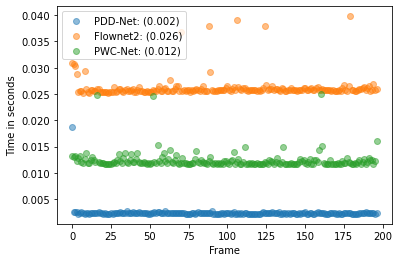

In [51]:
plt.scatter(np.arange(base_time.shape[0]), base_time, alpha=0.5, label=f'PDD-Net: ({round(base_time.mean().item(),5)})')
plt.scatter(np.arange(base_time.shape[0]), flow_time, alpha=0.5, label=f'Flownet2: ({round(flow_time.mean().item(),5)})')
plt.scatter(np.arange(base_time.shape[0]), pwc_time, alpha=0.5, label=f'PWC-Net: ({round(pwc_time.mean().item(),5)})')

plt.legend(loc='upper left')
plt.ylabel('Time in seconds')
plt.xlabel('Frame')

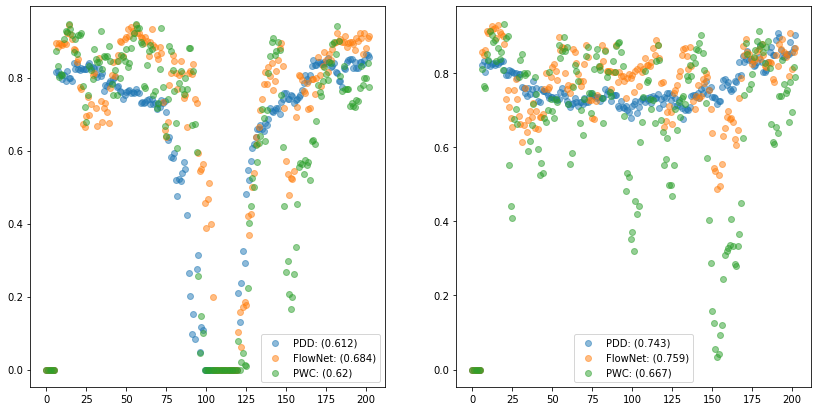

In [52]:
fig,ax = plt.subplots(1,2, figsize=(14,7))

ax[0].scatter(np.arange(base_dice.shape[0]), base_dice[:,0], alpha=0.5, label=f'PDD: ({round(base_dice[:,0].mean().item(),5)})')
ax[0].scatter(np.arange(base_dice.shape[0]), flow_dice[:,0], alpha=0.5, label=f'FlowNet: ({round(flow_dice[:,0].mean().item(),5)})')
ax[0].scatter(np.arange(base_dice.shape[0]), pwc_dice[:,0], alpha=0.5, label=f'PWC: ({round(pwc_dice[:,0].mean().item(),5)})')
ax[0].legend()

ax[1].scatter(np.arange(base_dice.shape[0]), base_dice[:,1], alpha=0.5, label=f'PDD: ({round(base_dice[:,1].mean().item(),5)})')
ax[1].scatter(np.arange(base_dice.shape[0]), flow_dice[:,1], alpha=0.5, label=f'FlowNet: ({round(flow_dice[:,1].mean().item(),5)})')
ax[1].scatter(np.arange(base_dice.shape[0]), pwc_dice[:,1], alpha=0.5, label=f'PWC: ({round(pwc_dice[:,1].mean().item(),5)})')
ax[1].legend()

In [53]:
distance_between_frames = 6

base_segs = torch.zeros(segs.shape)
pwc_segs = torch.zeros(segs.shape)
flow_segs = torch.zeros(segs.shape)


base_time = torch.zeros(frames.shape[0] - distance_between_frames)
pwc_time = torch.zeros(frames.shape[0] - distance_between_frames)
flow_time = torch.zeros(frames.shape[0] - distance_between_frames)


base_dice = torch.zeros(frames.shape[0],2)
pwc_dice = torch.zeros(frames.shape[0],2)
flow_dice = torch.zeros(frames.shape[0],2)

for i, frame in enumerate(frames):
    
    # skipp first X frames
    if i < distance_between_frames:
        continue
     # skipp first X frames
    if i < distance_between_frames:
        continue
    if i-distance_between_frames <= last_segment_available:
        fixed = torch.clone(frames[i- distance_between_frames])
        fixed_seg = torch.clone(segs[i-distance_between_frames])
    
    if i-distance_between_frames > last_segment_available:
        fixed = torch.clone(frames[last_segment_available])
        fixed_seg = torch.clone(segs[last_segment_available])
    
    moving = torch.clone(frames[i])
    moving_seg = torch.clone(segs[i])
    
    
    # BASELINE (PDD on Soft targets)
    base_seg, run_time_base = pdd_warp(ensemble_model, fixed, moving, fixed_seg, moving_seg)
    base_segs[i] = base_seg.detach().cpu()
    base_time[i-distance_between_frames] = run_time_base
    base_dice[i] = dice_coeff(moving_seg.cpu(), base_seg.cpu(), 3)
    # FLOWNET2
    warped_seg, run_time = flownet_warp(fixed.unsqueeze(0).unsqueeze(0),
                                         moving.unsqueeze(0).unsqueeze(0),
                                         fixed_seg,
                                         moving_seg)
    
    flow_segs[i] = warped_seg.detach().cpu()
    flow_time[i-distance_between_frames] = run_time
    flow_dice[i] = dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu()
    
    # PWC
    warped_seg, run_time = pwc_warp(fixed.unsqueeze(0).unsqueeze(0),
                                     moving.unsqueeze(0).unsqueeze(0),
                                     fixed_seg,
                                     moving_seg)
    pwc_segs[i] = warped_seg.detach().cpu()
    pwc_time[i-distance_between_frames] = run_time
    pwc_dice[i] = dice_coeff(moving_seg.cpu(), warped_seg, 3).cpu()

<IPython.core.display.Javascript object>


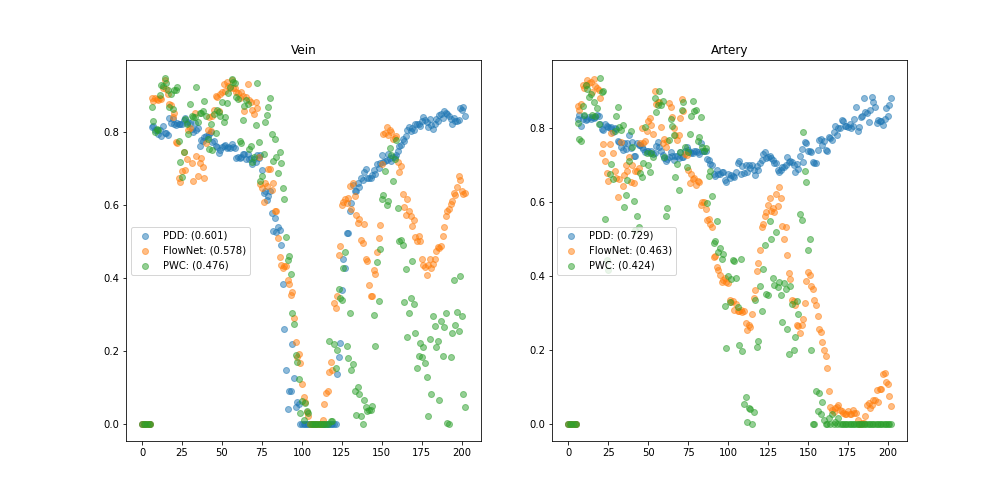

In [63]:
fig,ax = plt.subplots(1,2, figsize=(14,7))

ax[0].scatter(np.arange(base_dice.shape[0]), base_dice[:,0], alpha=0.5, label=f'PDD: ({round(base_dice[:,0].mean().item(),3)})')
ax[0].scatter(np.arange(base_dice.shape[0]), flow_dice[:,0], alpha=0.5, label=f'FlowNet: ({round(flow_dice[:,0].mean().item(),3)})')
ax[0].scatter(np.arange(base_dice.shape[0]), pwc_dice[:,0], alpha=0.5, label=f'PWC: ({round(pwc_dice[:,0].mean().item(),3)})')
ax[0].set_title('Vein')
ax[0].annotate(f"Last Segmentation: {last_segment_available}", xy=(last_segment_available, 1), xytext=(last_segment_available, 1),arrowprops=dict(facecolor='red', shrink=0.01))
ax[0].legend()

ax[1].scatter(np.arange(base_dice.shape[0]), base_dice[:,1], alpha=0.5, label=f'PDD: ({round(base_dice[:,1].mean().item(),3)})')
ax[1].scatter(np.arange(base_dice.shape[0]), flow_dice[:,1], alpha=0.5, label=f'FlowNet: ({round(flow_dice[:,1].mean().item(),3)})')
ax[1].scatter(np.arange(base_dice.shape[0]), pwc_dice[:,1], alpha=0.5, label=f'PWC: ({round(pwc_dice[:,1].mean().item(),3)})')
ax[1].annotate(f"Last Segmentation: {last_segment_available}", xy=(last_segment_available, 1), xytext=(last_segment_available, 1),arrowprops=dict(facecolor='black', shrink=0.01))
ax[1].set_title('Artery')
ax[1].legend()

plt.show()

In [43]:
# trained distance between the frames
distance_between_frames = 6

# Storing Tensor for the warped segmentations and flowfields
warped_segs_pdd = torch.zeros(len(used_frames),1,150,150)
warped_segs_pwc_only = torch.zeros(len(used_frames),1,150,150)
warped_segs_enselmbe_trained = torch.zeros(len(used_frames),1,150,150)
warped_segs_baseline = torch.zeros(len(used_frames),1,150,150)
warped_segs_pwc = torch.zeros(len(used_frames),1,150,150)
scale=1

# Identitiy matrix for warping
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()

# iterate over 80 frames after the last available seg
for i, frame in enumerate(used_frames):
    # we cannot infer anything here
    if i < distance_between_frames:
        continue
        
    fixed = torch.clone(used_frames[0]).unsqueeze(0).unsqueeze(0)
    fixed_seg = torch.clone(used_segs[0]).unsqueeze(0).unsqueeze(0)
    moving = torch.clone(used_frames[i].unsqueeze(0).unsqueeze(0))
    
    if len(torch.where(torch.histc(fixed_seg) != 0)[0]) == 3 and fixed_seg.max() <= 1:
            fixed_seg = fixed_seg*2
    
    ##### enselmble trained
    fixed_feat = ensemble_trained(fixed.cuda()).detach()
    # etract featuers for moving frame
    moving_feat = ensemble_trained(moving.cuda()).detach()
    # compute the currelation and flow field
    ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
    #regularise using meanfield inference with approx. min-convolutions
    soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    
    #upsample field to original resolution
    dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic', align_corners=False)#.cuda()

    #apply and evaluate transformation
    warped_seg = F.grid_sample(fixed_seg.cuda().float(),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    # store the warped seg
    warped_segs_enselmbe_trained[i] = torch.clone(warped_seg.cpu())
    
    ##### SOFT PWC trained
    fixed_feat = pwc_only(fixed.cuda()).detach()
    # etract featuers for moving frame
    moving_feat = pwc_only(moving.cuda()).detach()
    # compute the currelation and flow field
    ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
    #regularise using meanfield inference with approx. min-convolutions
    soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    
    #upsample field to original resolution
    dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic', align_corners=False)#.cuda()

    #apply and evaluate transformation
    warped_seg = F.grid_sample(fixed_seg.cuda().float(),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    # store the warped seg
    warped_segs_pwc_only[i] = torch.clone(warped_seg.cpu())
    
    ##### PDD trained
    fixed_feat = pdd(fixed.cuda()).detach()
    # etract featuers for moving frame
    moving_feat = pdd(moving.cuda()).detach()
    # compute the currelation and flow field
    ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
    #regularise using meanfield inference with approx. min-convolutions
    soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
    
    #upsample field to original resolution
    dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic', align_corners=False)#.cuda()

    #apply and evaluate transformation
    warped_seg = F.grid_sample(fixed_seg.cuda().float(),identity+dense_flow_fit.flip(1).permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    # store the warped seg
    warped_segs_pdd[i] = torch.clone(warped_seg.cpu())

    ##### PWC-Net
    # Here we rescale the images for the Teacher 
    # the flownet expects intputs that match Nx64. 
    teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')

    # Generate the teacher flow estimation
    pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1)).cuda()
    pwc_flow = pwc(pwc_flow_in)
    pwc_flow = pwc_flow[0] * 40.0
    pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W))

    # warp the segmentations with pwc flow
    warped_pwc_seg = warp(fixed_seg.float().cuda(), pwc_flow.cuda()).cpu()
    
    warped_segs_pwc[i] = warped_pwc_seg
    
    
    #### Baseline
    flow_numpy = baseline.calc(fixed.squeeze().cpu().numpy().astype(np.float32), moving.squeeze().cpu().numpy().astype(np.float32), None)
    flow = torch.from_numpy(flow_numpy) * 0.05
        
    warped_baseline = warp(fixed_seg.float().cuda(), flow.reshape(2,150,150).unsqueeze(0).cuda()).cpu()
    warped_segs_baseline[i] = warped_baseline

<IPython.core.display.Javascript object>


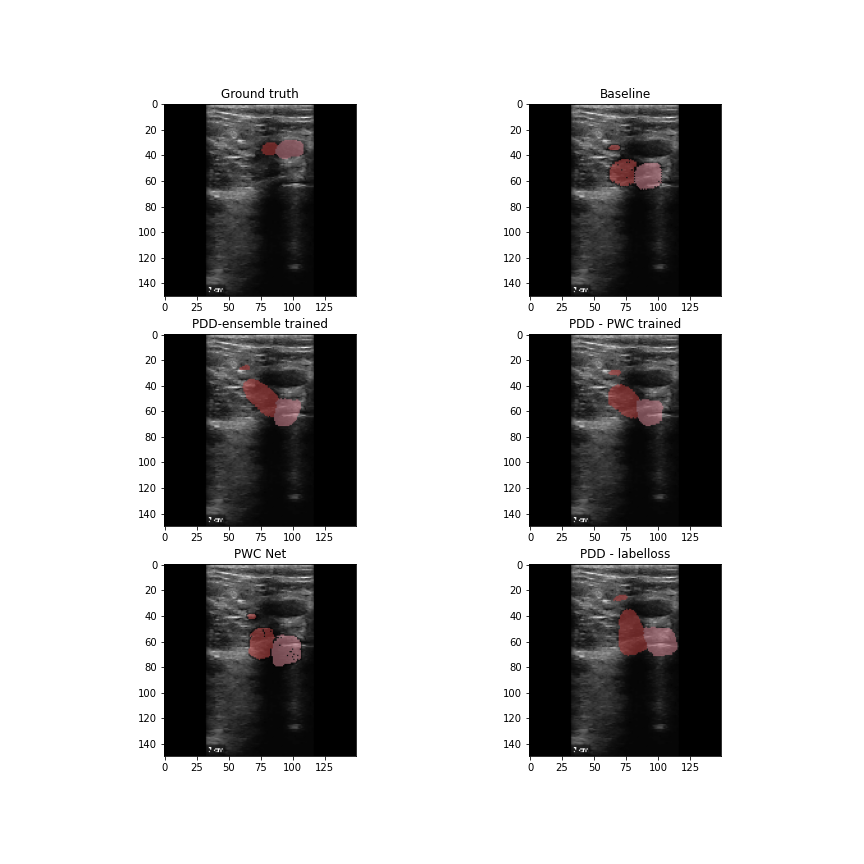

In [44]:
%matplotlib notebook

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

ax1.set_title('Ground truth')
ax2.set_title('Baseline')
ax3.set_title('PDD-ensemble trained')
ax4.set_title('PDD - PWC trained')
ax5.set_title('PWC Net')
ax6.set_title('PDD - labelloss')



lines = []
for i in range(len(used_frames)):
    overlay_ground = overlaySegment(used_frames[i], used_segs[i])
    overlay_baseline = overlaySegment(used_frames[i], warped_segs_baseline[i].squeeze())
    overlay_ensemble = overlaySegment(used_frames[i], warped_segs_enselmbe_trained[i].squeeze())
    overlay_pwc_trained = overlaySegment(used_frames[i], warped_segs_pwc_only[i].squeeze())
    overlay_pwc = overlaySegment(used_frames[i], warped_segs_pwc[i].squeeze())
    overlay_pdd = overlaySegment(used_frames[i], warped_segs_pdd[i].squeeze())
    
    
    ground_truth_image = ax1.imshow(overlay_ground, animated=True)
    baseline_image = ax2.imshow(overlay_baseline, animated=True)
    ensemble_image = ax3.imshow(overlay_ensemble, animated=True)
    pwc_trained_image = ax4.imshow(overlay_pwc_trained, animated=True)
    pwc_image = ax5.imshow(overlay_pwc, animated=True)
    pdd_image = ax6.imshow(overlay_pdd, animated=True)
    
    lines.append([ground_truth_image, baseline_image, ensemble_image, pwc_trained_image, pwc_image, pdd_image])
    
ani = animation.ArtistAnimation(fig,lines,interval=100,blit=True)
plt.show()

In [16]:
ani.save("/share/data_ultraschall/nicke_ma/eval_videos/comparisson_of_softTargetTrained.mp4")